In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import decimate
from gait_events import gait_events_HC_JA
from dtaidistance import dtw
from tqdm import tqdm
from tslearn.metrics import dtw
from tslearn.metrics import cdist_dtw
import json

/home/dmartinez/miniconda3/envs/inv_Di/lib/python3.10/site-packages/tslearn/bases/bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


In [3]:
# 0. Function definitios compute DTW distance matrix and summarize it
def compute_dtw_matrix(cycles, n_jobs=-1):
    """
    Receives a list of cycles (2D numpy array) and computes the DTW distance matrix.
    """
    return cdist_dtw(cycles, n_jobs=n_jobs)

def summarize_dtw_matrix(D):
    """
    from a DTW distance matrix, returns a dictionary with the mean, median, std and number of pairs.
    """
    triu_idxs = np.triu_indices_from(D, k=1)
    vals = D[triu_idxs]
    return {
        'mean':   float(np.mean(vals)),
        'median': float(np.median(vals)),
        'std':    float(np.std(vals)),
        'n_pairs': int(len(vals))
    }


In [4]:
# 1. Load patient data and define output folder 
def load_patient_data(patient_folder, patient_id):
    """
    Read all CSV files for a given patient and return a list of DataFrames and file paths.
    """
    df_list, file_list = [], []
    # Iterate over directory structure D01/D02 × B01–B03 × T01–T03
    for d in ['D01', 'D02']:
        for b in ['B01', 'B02', 'B03']:
            for t in ['T01', 'T02', 'T03']:
                fname = os.path.join(patient_folder,patient_id, f"{patient_id}_G01_{d}_{b}_{t}.csv")
                if os.path.exists(fname):
                    df = pd.read_csv(fname)
                    if not df.empty:
                        df_list.append(df)
                        file_list.append(fname)
                else:
                    print(f"File not found: {fname}")
    return df_list, file_list

# === Main analysis parameters ===
base_folder = './young adults (19–35 years old)'
output_base = './DTW_downsampled2'

# Create output directory if it does not exist
os.makedirs(output_base, exist_ok=True)

# Identify patient IDs in the base folder
patient_ids = sorted([f for f in os.listdir(base_folder) if f.startswith('S') and len(f) == 4])
print('Detected patients:', patient_ids)

summary = []

Detected patients: ['S002', 'S003', 'S004', 'S005', 'S006', 'S007', 'S008', 'S010', 'S012', 'S014', 'S015', 'S016', 'S017', 'S018', 'S020', 'S021', 'S023', 'S024', 'S025', 'S026', 'S027', 'S028', 'S030', 'S031', 'S032', 'S033', 'S034', 'S035', 'S036', 'S037', 'S038', 'S039', 'S063']


In [5]:
# 2. Function to segment and downsample gait cycles
def segment_downsamp(df,
                   signal_col='Ankle Dorsiflexion RT (deg)',
                   min_length=20,# make sure this is long enough to avoid spurious segments
                   downsample_factor=4):
    """
    1. Detect heel strikes on the original 200 Hz data.
    2. Slice out each gait cycle between strikes.
    3. Enforce a minimum length to avoid spurious segments.
    4. Normalize each cycle (zero-mean, unit-variance).
    5. Downsample each cycle from 200 Hz to 50 Hz.
    """
    # 1) Detect right heel strikes
    hs_R, _, _, _ = gait_events_HC_JA(df)
    series = df[signal_col].interpolate().values

    cycles = []
    # Sort the strike indices
    hs = sorted(int(i) for i in hs_R)

    # 2) & 3) Extract raw cycles
    for start, end in zip(hs, hs[1:]):
        cycle = series[start:end]
        if len(cycle) >= min_length:
            # Only downsample if the cycle length is large enough
            if len(cycle) > 27:  # 27 to handle padding requirements in decimate
                # Apply Z-score normalization
                cycle = (cycle - np.mean(cycle)) / np.std(cycle)
                # Downsample to 50 Hz
                cycle = decimate(cycle, downsample_factor, zero_phase=True)
                cycles.append(cycle)
            else:
                # Skip cycles too short for downsampling
                print(f"Skipping cycle of length {len(cycle)} (too short for downsampling).")
                
    return cycles

In [ ]:
# 3. DTW distance matrix
results = []

for pid in tqdm(patient_ids, desc="Pacientes"):
    # load_patient_data returns a list of DataFrames and file paths
    dfs, paths = load_patient_data(base_folder, pid)
    for df_trial, filepath in zip(dfs, paths):
    
        #To extract the trial ID from the file path
        trial_id = os.path.basename(filepath).replace('.csv', '')
        
        # 1) segment and downsample the data
        cycles = segment_downsamp(df_trial, min_length=20, downsample_factor=4)
        
        # 2) DTW distance matrix if there are at least 2 cycles
        if len(cycles) > 1:
            D = compute_dtw_matrix(cycles, n_jobs=-1)
            stats = summarize_dtw_matrix(D)
        else:
            # if there are not enough cycles, set stats to NaN
            stats = {'mean': np.nan, 'median': np.nan, 'std': np.nan, 'n_pairs': 0}
        
        # 3) Add the results to the summary creating a dictionary
        results.append({
            'patient_id': pid,
            'trial_id':   trial_id,
            'n_cycles':   len(cycles),
            **stats
        })

Pacientes:   0%|          | 0/33 [00:00<?, ?it/s]

Skipping cycle of length 21 (too short for downsampling).
Skipping cycle of length 24 (too short for downsampling).
Skipping cycle of length 26 (too short for downsampling).


Pacientes:   3%|▎         | 1/33 [02:31<1:21:02, 151.94s/it]

Skipping cycle of length 24 (too short for downsampling).
Skipping cycle of length 21 (too short for downsampling).
Skipping cycle of length 25 (too short for downsampling).
Skipping cycle of length 21 (too short for downsampling).
Skipping cycle of length 25 (too short for downsampling).
Skipping cycle of length 20 (too short for downsampling).
Skipping cycle of length 24 (too short for downsampling).
Skipping cycle of length 23 (too short for downsampling).
Skipping cycle of length 26 (too short for downsampling).
Skipping cycle of length 23 (too short for downsampling).
Skipping cycle of length 27 (too short for downsampling).
Skipping cycle of length 23 (too short for downsampling).
Skipping cycle of length 24 (too short for downsampling).
Skipping cycle of length 21 (too short for downsampling).
Skipping cycle of length 27 (too short for downsampling).
Skipping cycle of length 27 (too short for downsampling).
Skipping cycle of length 24 (too short for downsampling).
Skipping cycle

Pacientes:  15%|█▌        | 5/33 [17:49<1:35:31, 204.70s/it]

Skipping cycle of length 27 (too short for downsampling).
Skipping cycle of length 24 (too short for downsampling).
Skipping cycle of length 24 (too short for downsampling).
Skipping cycle of length 24 (too short for downsampling).
Skipping cycle of length 27 (too short for downsampling).
Skipping cycle of length 21 (too short for downsampling).
Skipping cycle of length 23 (too short for downsampling).
Skipping cycle of length 21 (too short for downsampling).
Skipping cycle of length 23 (too short for downsampling).
Skipping cycle of length 21 (too short for downsampling).
Skipping cycle of length 22 (too short for downsampling).
Skipping cycle of length 23 (too short for downsampling).
Skipping cycle of length 24 (too short for downsampling).
Skipping cycle of length 25 (too short for downsampling).
Skipping cycle of length 23 (too short for downsampling).
Skipping cycle of length 25 (too short for downsampling).
Skipping cycle of length 27 (too short for downsampling).
Skipping cycle

Pacientes:  18%|█▊        | 6/33 [23:28<1:52:33, 250.12s/it]

Skipping cycle of length 20 (too short for downsampling).
Skipping cycle of length 23 (too short for downsampling).


Pacientes:  21%|██        | 7/33 [27:30<1:47:16, 247.57s/it]

Skipping cycle of length 20 (too short for downsampling).
Skipping cycle of length 20 (too short for downsampling).
Skipping cycle of length 21 (too short for downsampling).
Skipping cycle of length 20 (too short for downsampling).
Skipping cycle of length 21 (too short for downsampling).
Skipping cycle of length 21 (too short for downsampling).
Skipping cycle of length 21 (too short for downsampling).
Skipping cycle of length 20 (too short for downsampling).
Skipping cycle of length 22 (too short for downsampling).
Skipping cycle of length 22 (too short for downsampling).
Skipping cycle of length 21 (too short for downsampling).
Skipping cycle of length 20 (too short for downsampling).
Skipping cycle of length 22 (too short for downsampling).
Skipping cycle of length 20 (too short for downsampling).
Skipping cycle of length 20 (too short for downsampling).
Skipping cycle of length 20 (too short for downsampling).
Skipping cycle of length 21 (too short for downsampling).
Skipping cycle

Pacientes:  27%|██▋       | 9/33 [34:08<1:29:10, 222.93s/it]

Skipping cycle of length 22 (too short for downsampling).


Pacientes:  30%|███       | 10/33 [36:45<1:17:34, 202.36s/it]

Skipping cycle of length 23 (too short for downsampling).
Skipping cycle of length 23 (too short for downsampling).
Skipping cycle of length 23 (too short for downsampling).
Skipping cycle of length 23 (too short for downsampling).
Skipping cycle of length 20 (too short for downsampling).
Skipping cycle of length 21 (too short for downsampling).
Skipping cycle of length 23 (too short for downsampling).
Skipping cycle of length 22 (too short for downsampling).
Skipping cycle of length 22 (too short for downsampling).
Skipping cycle of length 25 (too short for downsampling).
Skipping cycle of length 24 (too short for downsampling).
Skipping cycle of length 27 (too short for downsampling).
Skipping cycle of length 23 (too short for downsampling).
Skipping cycle of length 21 (too short for downsampling).
Skipping cycle of length 20 (too short for downsampling).


Pacientes:  36%|███▋      | 12/33 [43:10<1:09:00, 197.17s/it]

File not found: ./young adults (19–35 years old)/S017/S017_G01_D02_B01_T01.csv
File not found: ./young adults (19–35 years old)/S017/S017_G01_D02_B01_T02.csv
File not found: ./young adults (19–35 years old)/S017/S017_G01_D02_B01_T03.csv
File not found: ./young adults (19–35 years old)/S017/S017_G01_D02_B02_T01.csv
File not found: ./young adults (19–35 years old)/S017/S017_G01_D02_B02_T02.csv
File not found: ./young adults (19–35 years old)/S017/S017_G01_D02_B02_T03.csv
File not found: ./young adults (19–35 years old)/S017/S017_G01_D02_B03_T01.csv
File not found: ./young adults (19–35 years old)/S017/S017_G01_D02_B03_T02.csv
File not found: ./young adults (19–35 years old)/S017/S017_G01_D02_B03_T03.csv


Pacientes:  39%|███▉      | 13/33 [44:32<54:02, 162.11s/it]  

Skipping cycle of length 27 (too short for downsampling).


Pacientes:  48%|████▊     | 16/33 [54:23<52:34, 185.56s/it]

Skipping cycle of length 23 (too short for downsampling).
Skipping cycle of length 24 (too short for downsampling).
Skipping cycle of length 21 (too short for downsampling).
Skipping cycle of length 21 (too short for downsampling).
Skipping cycle of length 21 (too short for downsampling).
Skipping cycle of length 21 (too short for downsampling).
Skipping cycle of length 20 (too short for downsampling).
Skipping cycle of length 21 (too short for downsampling).
Skipping cycle of length 23 (too short for downsampling).


Pacientes:  61%|██████    | 20/33 [1:07:42<43:47, 202.12s/it]

Skipping cycle of length 21 (too short for downsampling).
Skipping cycle of length 23 (too short for downsampling).


Pacientes:  64%|██████▎   | 21/33 [1:10:39<38:54, 194.52s/it]

Skipping cycle of length 21 (too short for downsampling).
Skipping cycle of length 22 (too short for downsampling).


Pacientes:  73%|███████▎  | 24/33 [1:22:11<32:04, 213.84s/it]

Skipping cycle of length 26 (too short for downsampling).
Skipping cycle of length 26 (too short for downsampling).
Skipping cycle of length 25 (too short for downsampling).
Skipping cycle of length 27 (too short for downsampling).
Skipping cycle of length 24 (too short for downsampling).
Skipping cycle of length 26 (too short for downsampling).
Skipping cycle of length 25 (too short for downsampling).
Skipping cycle of length 24 (too short for downsampling).
Skipping cycle of length 25 (too short for downsampling).
Skipping cycle of length 24 (too short for downsampling).
Skipping cycle of length 22 (too short for downsampling).
Skipping cycle of length 25 (too short for downsampling).
Skipping cycle of length 23 (too short for downsampling).
Skipping cycle of length 26 (too short for downsampling).
Skipping cycle of length 26 (too short for downsampling).
Skipping cycle of length 25 (too short for downsampling).
Skipping cycle of length 26 (too short for downsampling).
Skipping cycle

Pacientes:  82%|████████▏ | 27/33 [1:31:44<20:00, 200.14s/it]

Skipping cycle of length 21 (too short for downsampling).
Skipping cycle of length 24 (too short for downsampling).
Skipping cycle of length 25 (too short for downsampling).
Skipping cycle of length 22 (too short for downsampling).
Skipping cycle of length 24 (too short for downsampling).
Skipping cycle of length 20 (too short for downsampling).
Skipping cycle of length 22 (too short for downsampling).
Skipping cycle of length 20 (too short for downsampling).
Skipping cycle of length 23 (too short for downsampling).
Skipping cycle of length 23 (too short for downsampling).
Skipping cycle of length 20 (too short for downsampling).
Skipping cycle of length 26 (too short for downsampling).
Skipping cycle of length 24 (too short for downsampling).
Skipping cycle of length 20 (too short for downsampling).
Skipping cycle of length 21 (too short for downsampling).
Skipping cycle of length 20 (too short for downsampling).
Skipping cycle of length 22 (too short for downsampling).
Skipping cycle

Pacientes:  88%|████████▊ | 29/33 [1:40:11<15:25, 231.50s/it]

Skipping cycle of length 22 (too short for downsampling).
Skipping cycle of length 23 (too short for downsampling).
Skipping cycle of length 21 (too short for downsampling).
Skipping cycle of length 22 (too short for downsampling).
Skipping cycle of length 21 (too short for downsampling).
Skipping cycle of length 21 (too short for downsampling).
Skipping cycle of length 23 (too short for downsampling).
Skipping cycle of length 20 (too short for downsampling).
Skipping cycle of length 23 (too short for downsampling).
Skipping cycle of length 24 (too short for downsampling).
Skipping cycle of length 22 (too short for downsampling).
Skipping cycle of length 26 (too short for downsampling).
Skipping cycle of length 22 (too short for downsampling).
Skipping cycle of length 21 (too short for downsampling).
Skipping cycle of length 24 (too short for downsampling).
Skipping cycle of length 22 (too short for downsampling).
Skipping cycle of length 22 (too short for downsampling).
Skipping cycle

Pacientes:  91%|█████████ | 30/33 [1:45:44<13:05, 261.84s/it]

Skipping cycle of length 24 (too short for downsampling).


Pacientes:  94%|█████████▍| 31/33 [1:48:57<08:02, 241.13s/it]

Skipping cycle of length 20 (too short for downsampling).
Skipping cycle of length 24 (too short for downsampling).
Skipping cycle of length 27 (too short for downsampling).
Skipping cycle of length 25 (too short for downsampling).
Skipping cycle of length 20 (too short for downsampling).
Skipping cycle of length 27 (too short for downsampling).
Skipping cycle of length 21 (too short for downsampling).
Skipping cycle of length 22 (too short for downsampling).
Skipping cycle of length 24 (too short for downsampling).
Skipping cycle of length 20 (too short for downsampling).
Skipping cycle of length 21 (too short for downsampling).
Skipping cycle of length 20 (too short for downsampling).
Skipping cycle of length 22 (too short for downsampling).
Skipping cycle of length 20 (too short for downsampling).
Skipping cycle of length 22 (too short for downsampling).
Skipping cycle of length 21 (too short for downsampling).
Skipping cycle of length 20 (too short for downsampling).
Skipping cycle

Pacientes:  97%|█████████▋| 32/33 [1:51:49<03:40, 220.55s/it]

Skipping cycle of length 21 (too short for downsampling).


Pacientes: 100%|██████████| 33/33 [2:00:15<00:00, 218.64s/it]


In [6]:
# save the intra trial results
df_results = pd.DataFrame(results)
df_results = df_results[['patient_id','trial_id','n_cycles','n_pairs','mean','median','std']]


print(df_results.head())
df_results.to_csv('dtw_intra_trial_stats.csv', index=False)
with open('dtw_intra_trial_stats.json','w') as f:
    json.dump(results, f, indent=2)

NameError: name 'results' is not defined

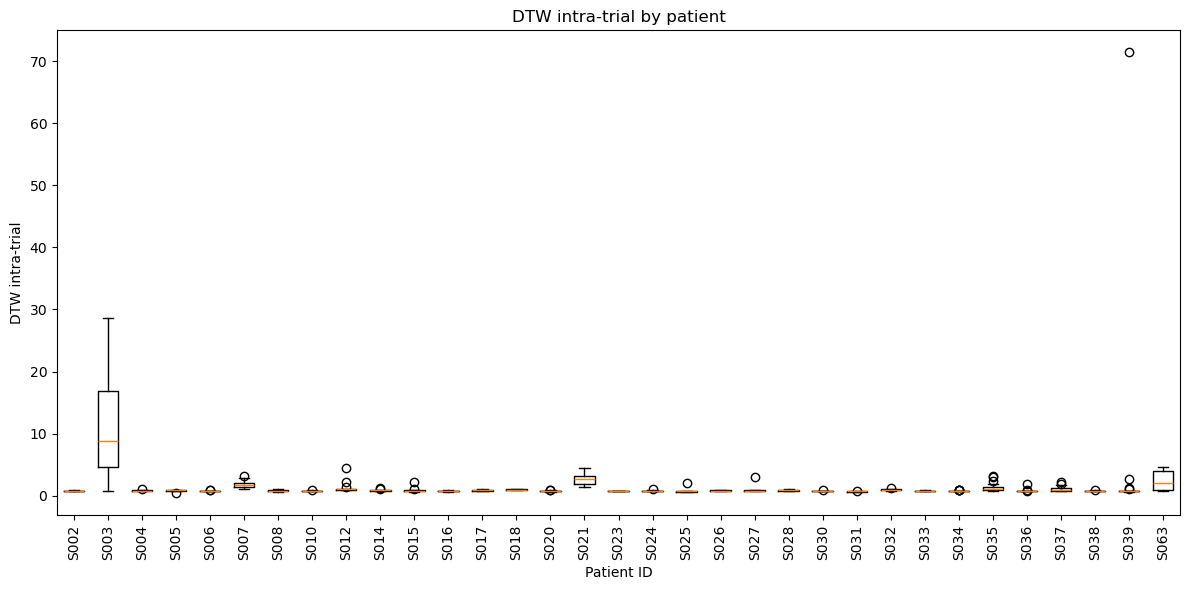

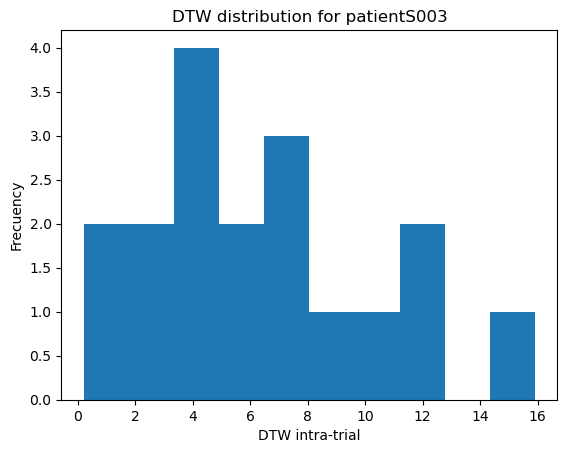

In [3]:
# Display the Inter trial results 
df = pd.read_csv('dtw_intra_trial_stats.csv')
patient_ids = sorted(df['patient_id'].unique())
position_map = {pid: i for i, pid in enumerate(patient_ids)}
flierprops = dict(marker='o', markerfacecolor='red', markersize=1, linestyle='none')
# 2) Boxplot of DTW STD for each patient
plt.figure(figsize=(12, 6))
for pid, grp in df.groupby('patient_id'):
    pos= position_map[pid]
    plt.boxplot(grp['mean'].dropna(), positions=[pos], widths=0.6)
plt.xlabel('Patient ID')
plt.xticks(list(position_map.values()), list(position_map.keys()), rotation=90)
plt.ylabel('DTW intra-trial')
plt.title('DTW intra-trial by patient')
plt.tight_layout()
plt.show()

# 3) DTW intra-trial distribution for a specific patient histogram
pac = 'S003'
plt.figure()
plt.hist(df.loc[df['patient_id']==pac, 'std'].dropna())
plt.xlabel('DTW intra-trial')
plt.ylabel('Frecuency')
plt.title(f'DTW distribution for patient{pac}')
plt.show()


/tmp/ipykernel_17297/3475049831.py:16: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


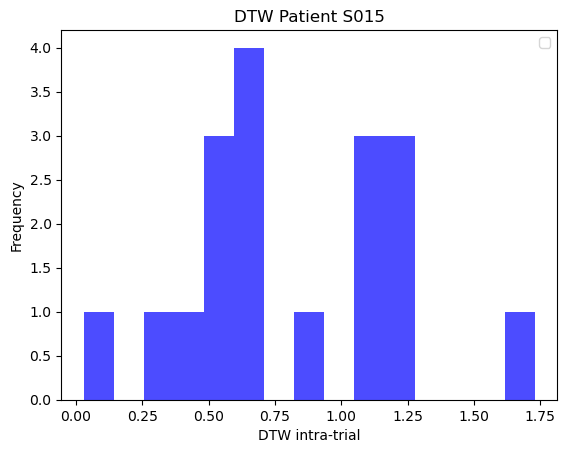

In [14]:
# Obtener los datos originales
pac = 'S015'
data = df.loc[df['patient_id'] == pac, 'std'].dropna()

# Generar datos con una distribución normal basada en la media y desviación estándar de los datos originales
mean = np.mean(data)
std = np.std(data)
normal_data = np.random.normal(loc=mean, scale=std, size=len(data))

# Graficar el histograma de los datos generados
plt.figure()
plt.hist(normal_data, bins=15, alpha=0.7, color='blue')
plt.xlabel('DTW intra-trial')
plt.ylabel('Frequency')
plt.title(f'DTW Patient {pac}')
plt.legend()
plt.show()

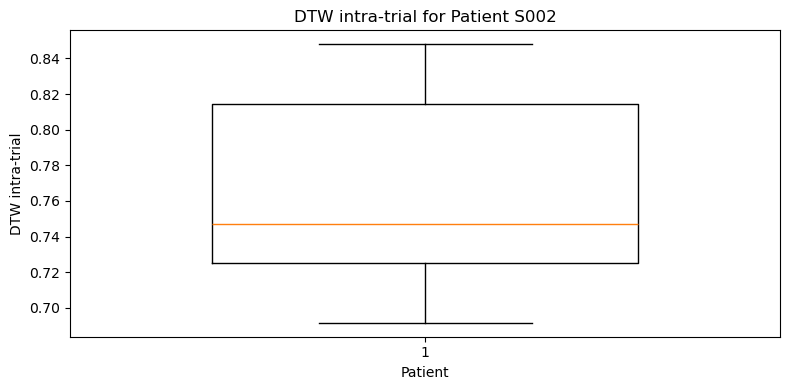

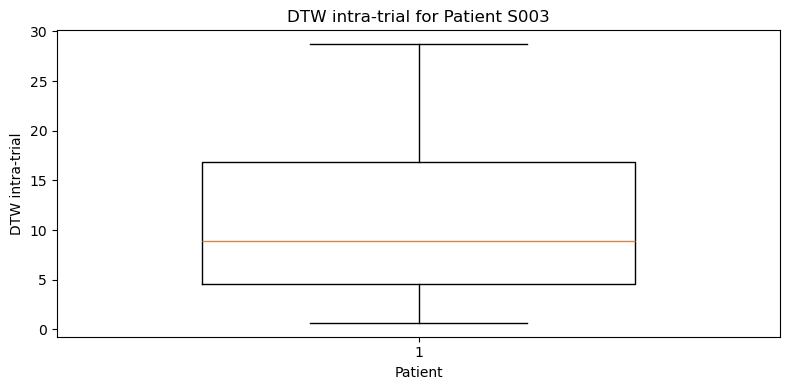

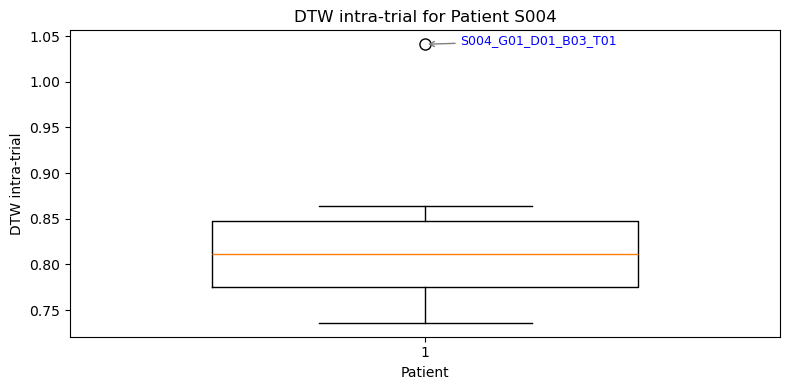

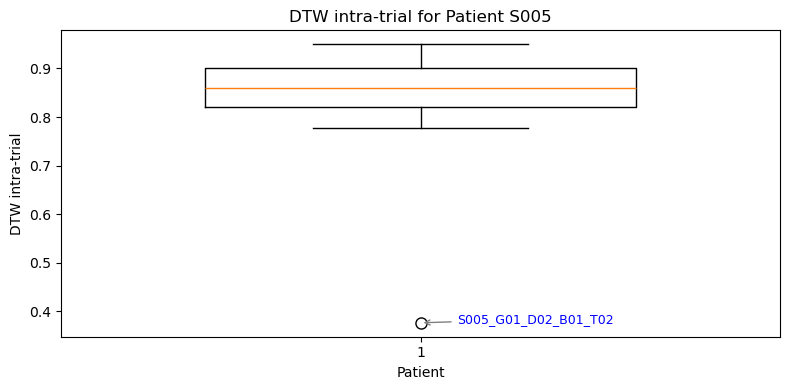

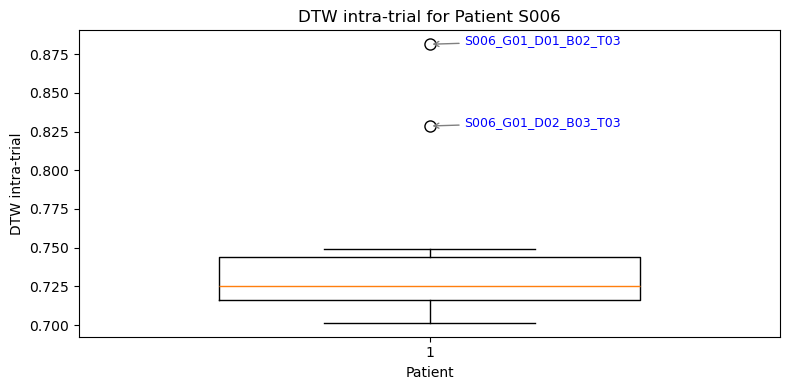

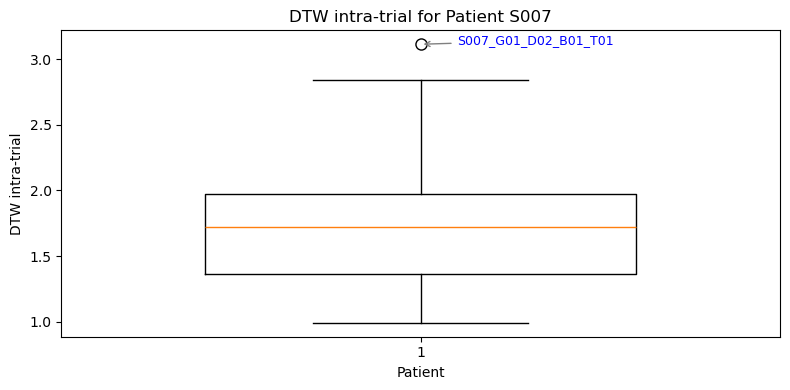

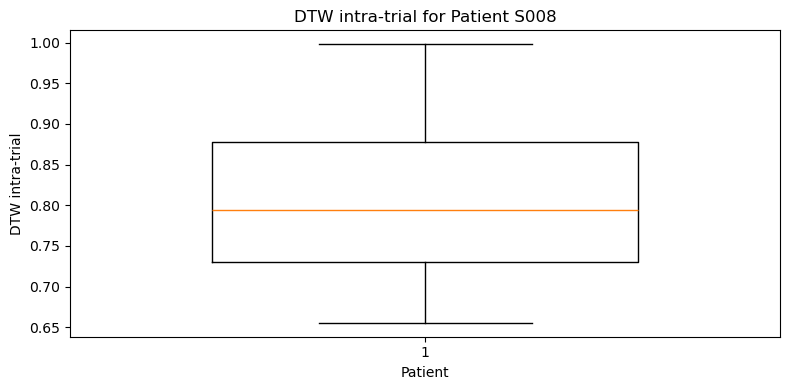

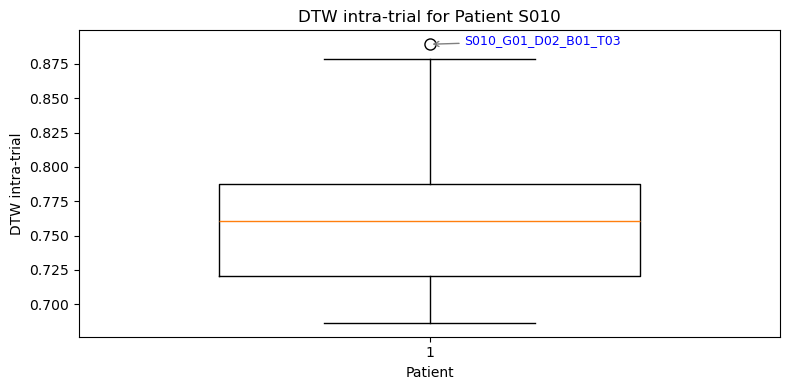

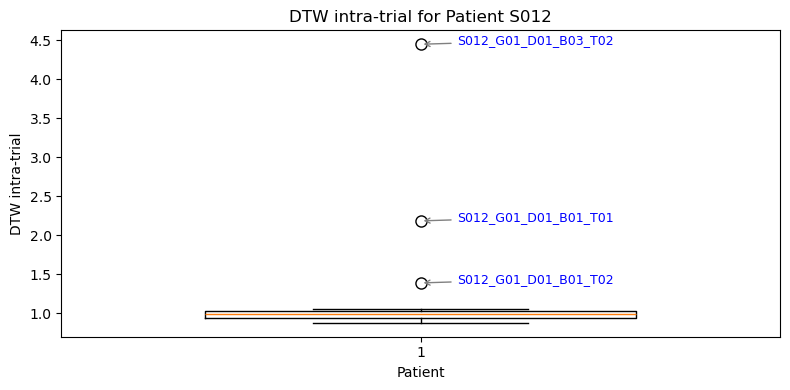

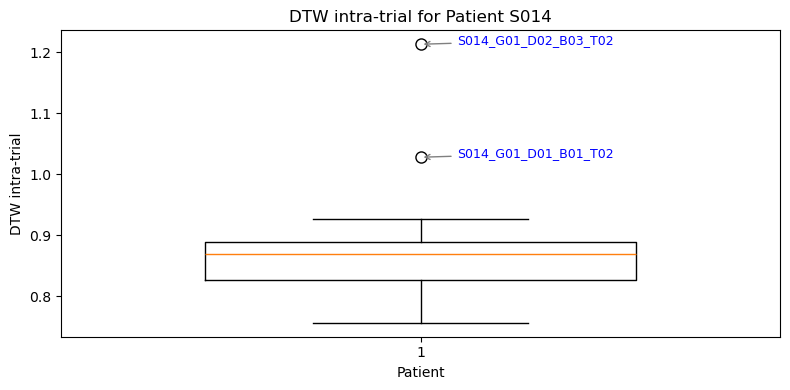

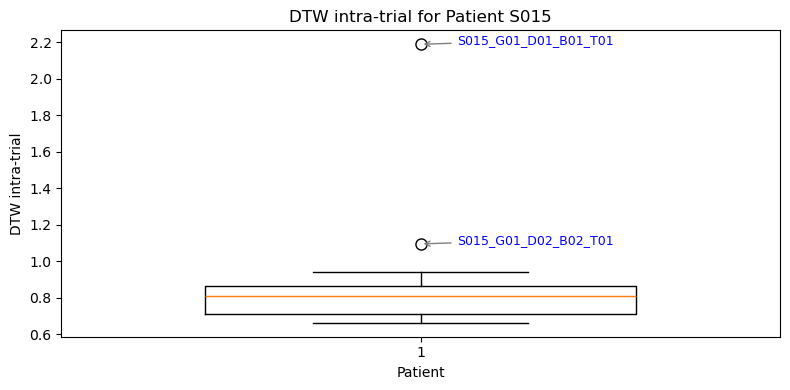

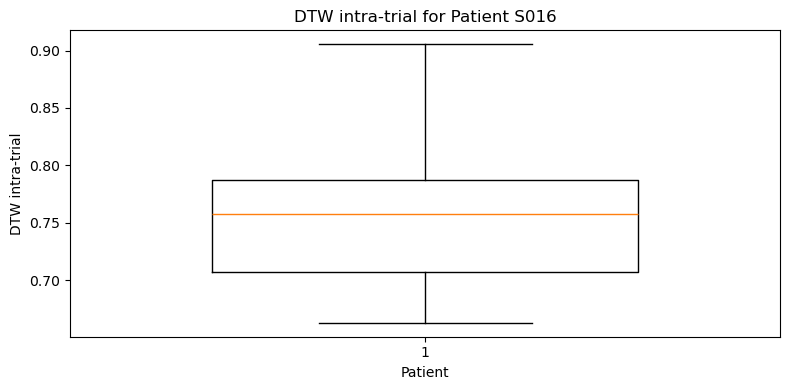

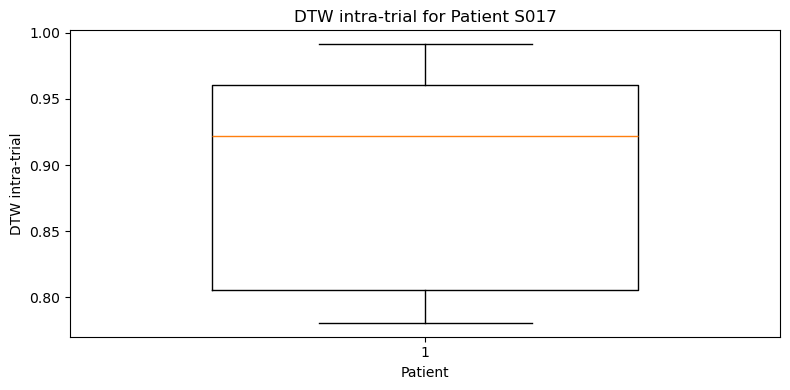

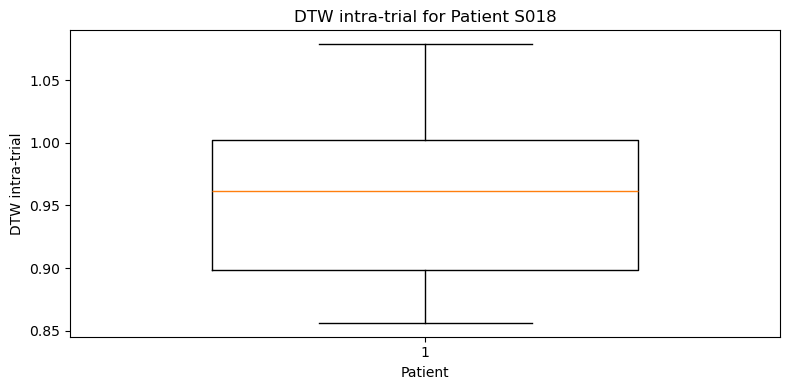

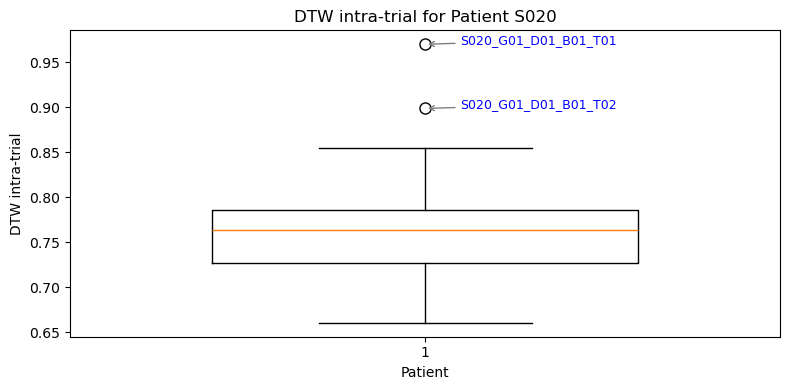

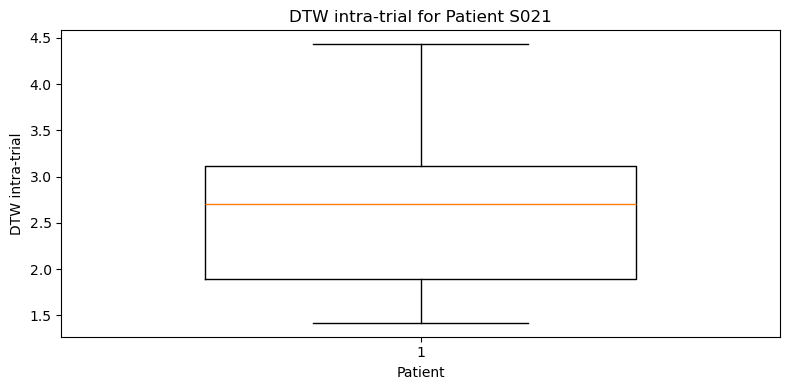

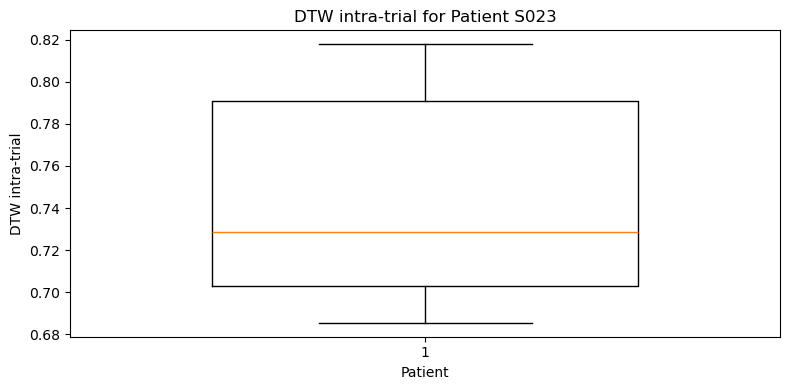

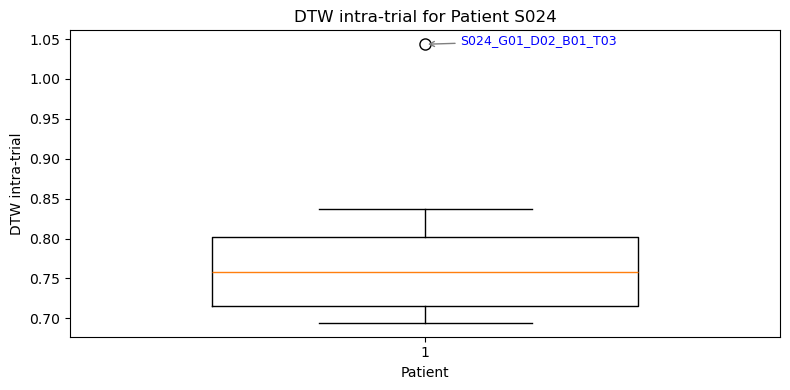

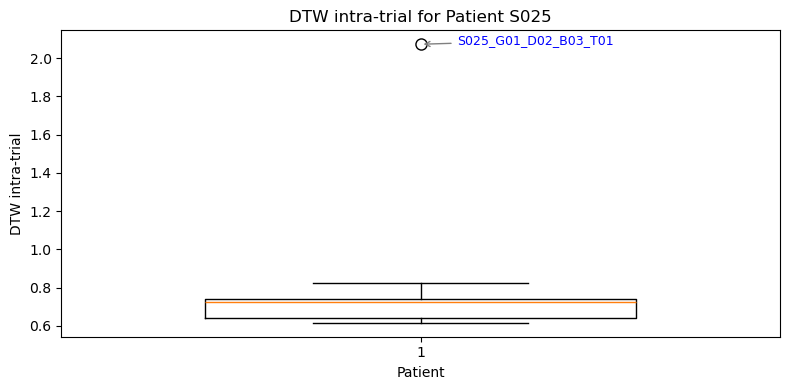

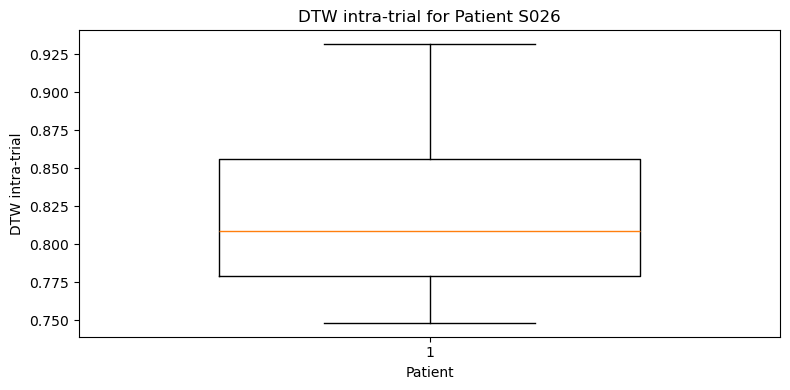

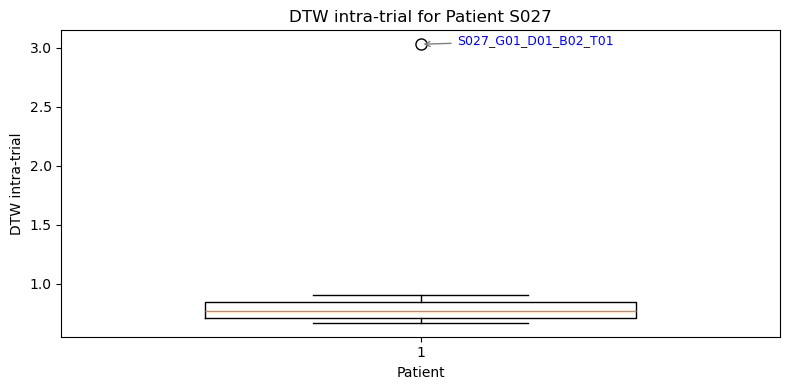

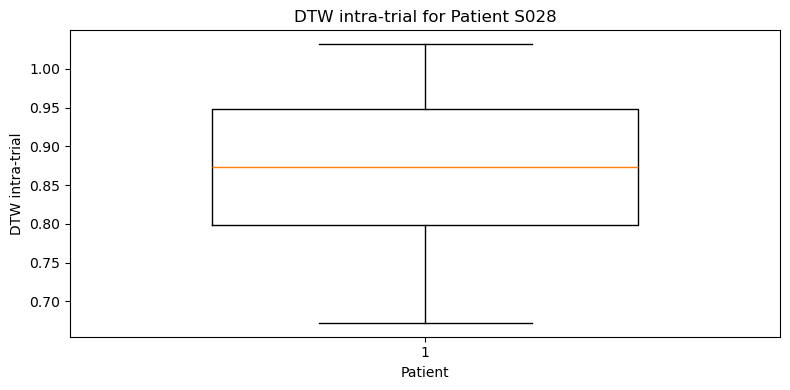

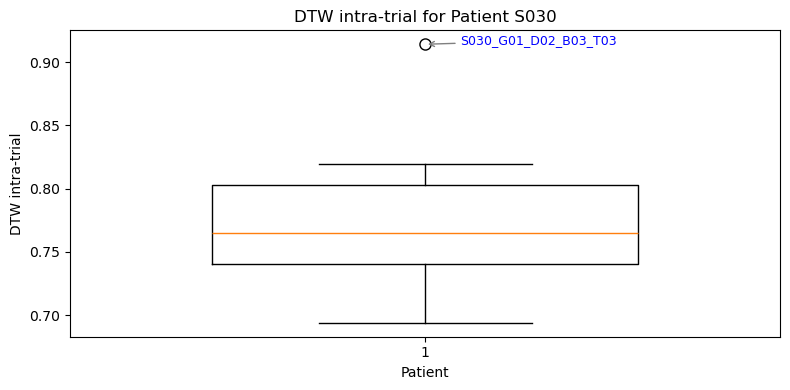

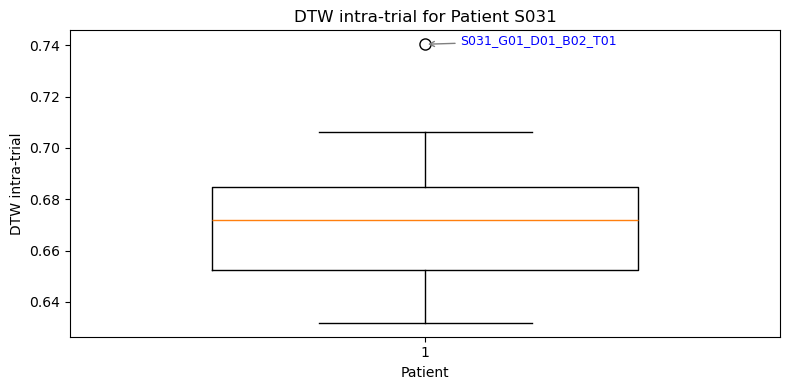

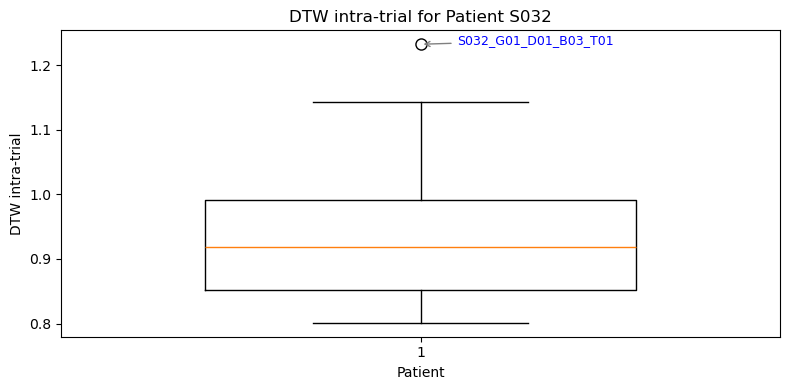

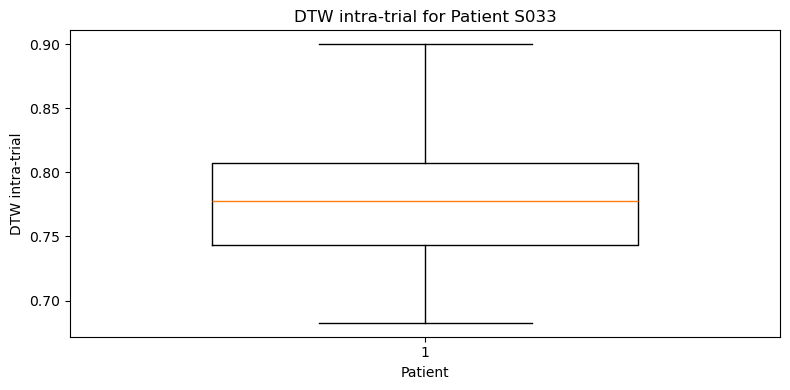

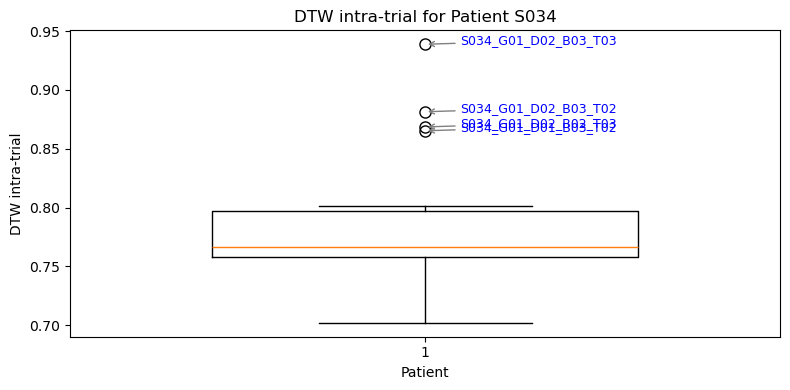

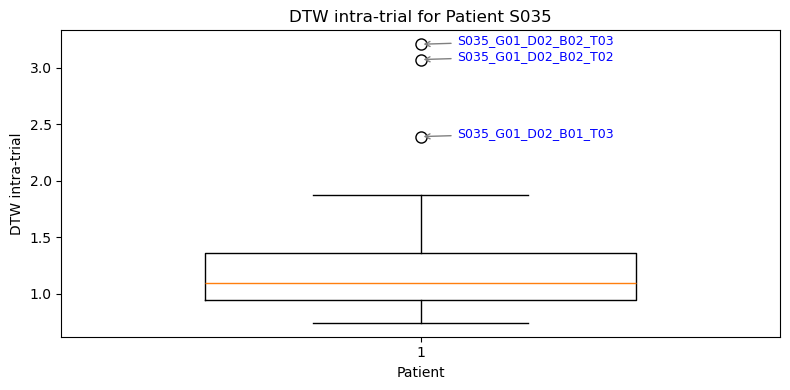

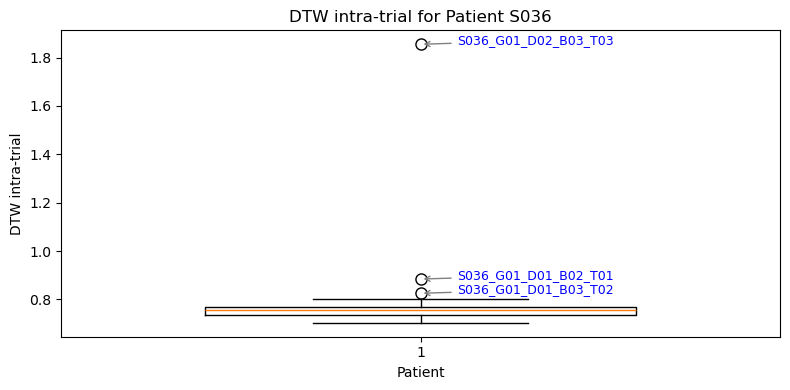

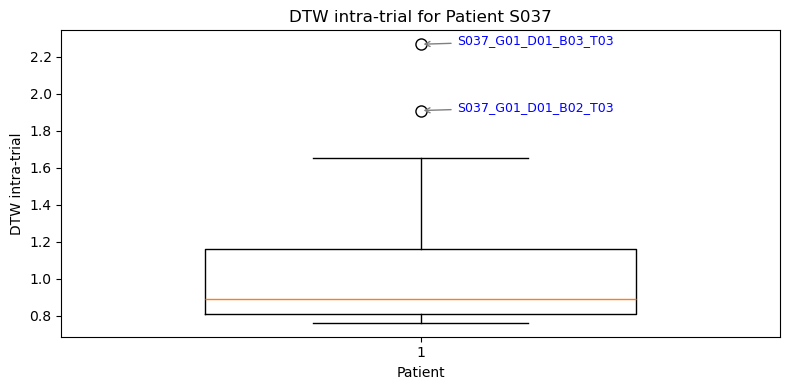

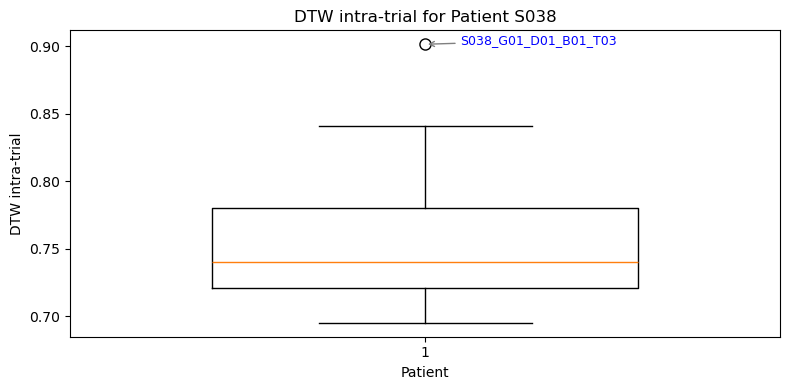

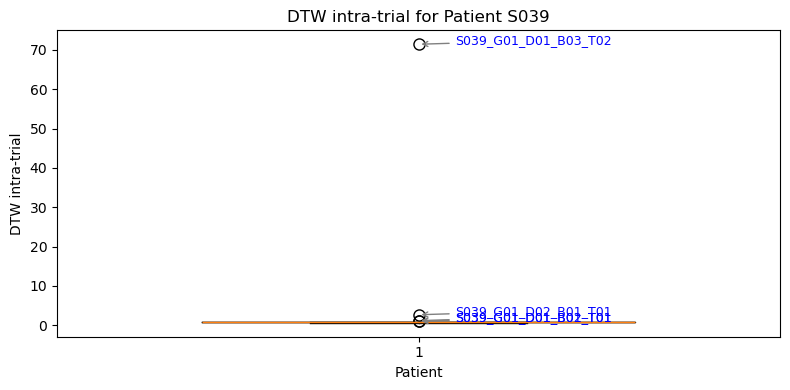

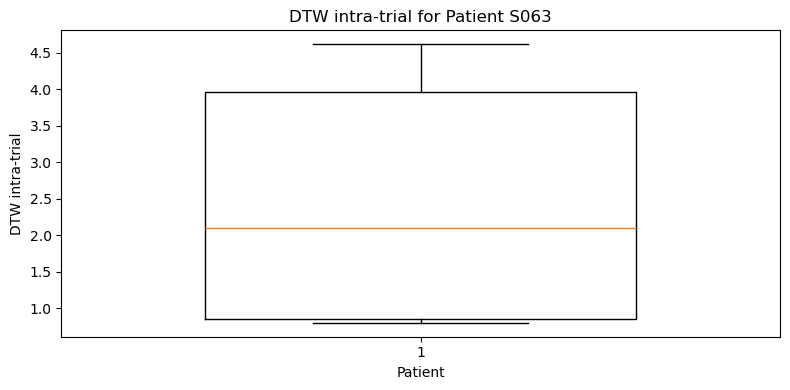

In [8]:
for pid, grp in df.groupby('patient_id'):
    plt.figure(figsize=(8, 4))  
    box = plt.boxplot(grp['mean'].dropna(), widths=0.6, flierprops={'marker': 'o', 'color': 'red', 'markersize': 8})
    outliers = box['fliers'][0].get_ydata()
    plt.title(f'DTW intra-trial for Patient {pid}')  
    plt.xlabel('Patient')  
    plt.ylabel('DTW intra-trial')  

    if len(outliers) > 0:
        for outlier in outliers:
            # Encontrar el índice del outlier en el grupo
            trial_name = grp.loc[grp['mean'] == outlier, 'trial_id'].values
            if len(trial_name) > 0:
                plt.annotate(f'{trial_name[0]}', xy=(1, outlier), xytext=(1.05, outlier),
                             textcoords='data', fontsize=9, color='blue',
                             arrowprops=dict(arrowstyle='->', color='gray'))

    plt.tight_layout()  
    plt.show()  

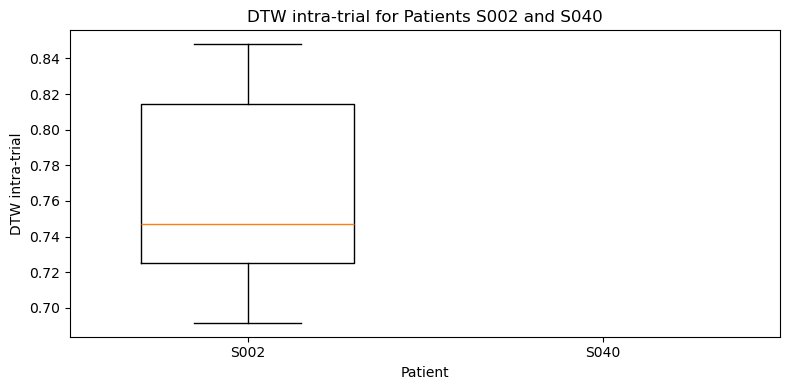

In [4]:

# Filtrar el DataFrame para obtener solo los datos de los pacientes S002 y S007
df_filtered = df[df['patient_id'].isin(['S002', 'S040'])]

# Crear el boxplot para los pacientes S002 y S007
plt.figure(figsize=(8, 4))
box = plt.boxplot([df_filtered[df_filtered['patient_id'] == 'S002']['mean'].dropna(),
                   df_filtered[df_filtered['patient_id'] == 'S040']['mean'].dropna()],
                  widths=0.6, flierprops={'marker': 'o', 'color': 'red', 'markersize': 8})

# Etiquetas de los ejes y título
plt.title('DTW intra-trial for Patients S002 and S040')
plt.xlabel('Patient')
plt.ylabel('DTW intra-trial')

# Etiquetas de los pacientes en el eje x
plt.xticks([1, 2], ['S002', 'S040'])

# Identificación de outliers (si los hay) y anotaciones
for i, patient_id in enumerate(['S002', 'S040'], 1):
    outliers = box['fliers'][i - 1].get_ydata()
    if len(outliers) > 0:
        for outlier in outliers:
            # Encontrar el índice del outlier en el grupo
            trial_name = df_filtered[(df_filtered['patient_id'] == patient_id) & 
                                     (df_filtered['mean'] == outlier)]['trial_id'].values
            if len(trial_name) > 0:
                plt.annotate(f'{trial_name[0]}', xy=(i, outlier), xytext=(i + 0.05, outlier),
                             textcoords='data', fontsize=9, color='blue',
                             arrowprops=dict(arrowstyle='->', color='gray'))

# Ajustar el diseño
plt.tight_layout()

# Mostrar el gráfico
plt.show()
